<a href="https://colab.research.google.com/github/sandra-Gaelle/AuthentiCheck/blob/main/Notebooks/authentikCheck_v1_mlops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Système de recommandation de textes basé sur un score d'authenticité (Content Authenticity Scoring & Recommendation Platform)**

Concevoir et déployer un système de recommandation de contenus fiables (non deepfake), capable d'évaluer automatiquement la crédibilité de contenus textuels à l'aide de modèles de NLP, et de les servir via une architecture MLOps scalable en environnement cloud.

**Objectif technique:**

- Entraîner un modèle NLP avec TensorFlow pour attribuer un score d'authenticité à des contenus textuels.

# Importer Tensorflow et les fonctions relatives

In [1]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.3 MB/s eta 0:00:00


In [2]:
import mlflow
import mlflow.tensorflow
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Chargement du Dataset et pretraitement des donnees

In [3]:
import kagglehub
import pandas as pd
import os

# Telechargement du dataset depuis Kaggle
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

# Chemin du fichier CSV
csv_file_path = os.path.join(path, "WELFake_Dataset.csv")

Using Colab cache for faster access to the 'fake-news-classification' dataset.
Path to dataset files: /kaggle/input/fake-news-classification


In [4]:
import numpy as np
import pandas as pd

news_df = pd.read_csv(csv_file_path)

# Suppression des lignes sans texte
news_df = news_df.dropna(subset=["text"])

# Mélange des données pour assurer une bonne distribution
news_df = news_df.sample(n=20000, random_state=42).reset_index(drop=True)

# Séparation des textes et labels
texts = news_df["text"].values
labels = news_df["label"].values


# Separation du jeu de donnees en train et test

In [5]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [6]:
from tensorflow.keras.layers import TextVectorization

# Paramètres
MAX_WORDS = 10000
MAX_LEN = 250

# Initialisation de la couche de vectorisation
vectorizer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_mode='int',
    output_sequence_length=MAX_LEN
)

vectorizer.adapt(train_texts)

# Construction du modele et configuration MLOPS

In [7]:
from mlflow.models.signature import infer_signature

# CONFIGURATION MLOPS

mlflow.set_experiment("Fake_News_Detection_Project_V1")
mlflow.tensorflow.autolog() # Enregistrement automatique des paramètres et logs

# Creation du modele

with mlflow.start_run():
  model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string), # Entrée : texte brut
        vectorizer,                                  # Couche de prétraitement intégrée
        tf.keras.layers.Embedding(MAX_WORDS, 128),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),                # Prévention du surapprentissage
        tf.keras.layers.Dense(1, activation='sigmoid') # Sortie : Probabilité (0: Fake, 1: True)
    ])

  model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
    )
  history = model.fit(
    train_texts, train_labels,
    epochs=4,
    validation_data=(val_texts, val_labels),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3) # Arrêt si le modèle ne progresse plus
    ]
)

# Calculate final metrics after training completes to make them available for logging
final_loss = history.history['val_loss'][-1]
final_accuracy = history.history['val_accuracy'][-1]
final_auc = history.history['val_auc'][-1]

# Enregistrement MLflow

signature = infer_signature(val_texts[:5], model.predict(val_texts[:5]))
mlflow.tensorflow.log_model(..., signature=signature)

mlflow.tensorflow.log_model(
    model,
    artifact_path="fake_news_model_registry",
    registered_model_name="FakeNewsClassifier"
)
print("🚀 Modèle enregistré dans le Model Registry de MLflow")


2026/02/25 14:55:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/25 14:55:53 INFO mlflow.store.db.utils: Updating database tables
2026/02/25 14:55:55 INFO mlflow.tracking.fluent: Experiment with name 'Fake_News_Detection_Project_V1' does not exist. Creating a new experiment.


# **Entrainement et suivi de metriques**

In [9]:
mlflow.log_metric("val_loss", final_loss)
mlflow.log_metric("val_accuracy", final_accuracy)
mlflow.log_metric("val_auc", final_auc)

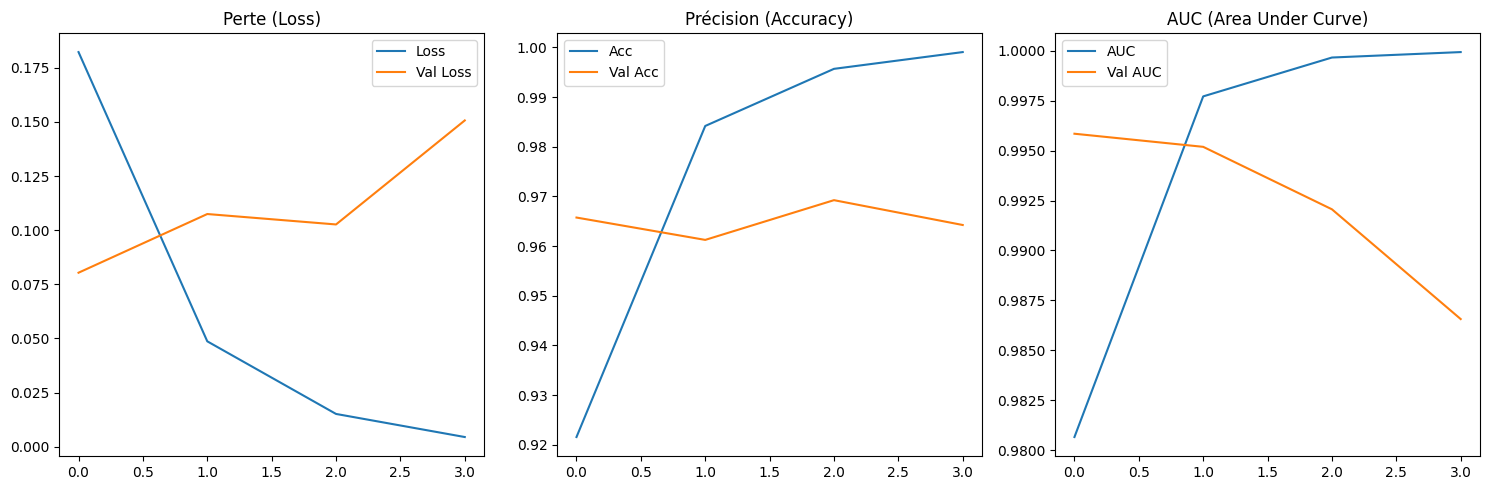

In [10]:
import matplotlib.pyplot as plt

# Affichage des courbes de performance
def plot_metrics(history):
    plt.figure(figsize=(15, 5)) # Increased figure size for better visualization of 3 subplots

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss') # Plotting the full validation loss curve
    plt.title('Perte (Loss)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc') # Plotting the full validation accuracy curve
    plt.title('Précision (Accuracy)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='AUC') # Correct metric name is 'auc' (lowercase)
    plt.plot(history.history['val_auc'], label='Val AUC') # Plotting the full validation AUC curve
    plt.title('AUC (Area Under Curve)') # More descriptive title
    plt.legend()

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show() # Call show only once after all subplots are created

plot_metrics(history)

# Prediction sur de nouvelles donnees

In [30]:
def predict_article(text, model, threshold=0.5):
    """
    Prédit si un article est fiable ou non.
    Retourne la probabilité et la classe.
    """

    # TensorFlow attend un batch → on met le texte dans une liste
    # Convertir en tensor explicitement

    text_tensor = tf.constant([text])

    prediction = model.predict([text_tensor])[0][0]

    label = "REAL" if prediction >= threshold else "FAKE"

    return {
        "probability_real": float(prediction),
        "prediction": label
    }


In [31]:
text = "ngrok is your app’s front door—a globally distributed reverse proxy that secures, protects and accelerates your applications and network services, no matter where you run them."

predict_article(text, model)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1,))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


{'probability_real': 0.998883843421936, 'prediction': 'REAL'}

# Sauvegarder le modele en local

In [13]:
# 1. Créer le dossier s'il n'existe pas
os.makedirs("models", exist_ok=True)

# 2. Sauvegarde locale du modele

model_path = "models/fake_news_model.keras"
model.save(model_path)
print(f"✅ Modèle sauvegardé localement sous : {model_path}")


2026/02/25 15:18:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 15:18:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


✅ Modèle sauvegardé localement sous : models/fake_news_model.keras
🚀 Modèle enregistré dans le Model Registry de MLflow


Successfully registered model 'FakeNewsClassifier'.
Created version '1' of model 'FakeNewsClassifier'.


In [14]:
# creation d'un tunnel pour exposer MLFlow

!pip install pyngrok

In [26]:
# 1. On tue toute instance précédente pour repartir à neuf
!pkill mlflow
!pkill ngrok

os.system("nohup mlflow ui --host 0.0.0.0 --port 5000 --disable-security-middleware > mlflow_log.txt 2>&1 &")

# 2. Attente et vérification active
import time
for i in range(10):
    print(f"⏳ Tentative de détection du serveur ({i+1}/10)...")
    time.sleep(3)
    # On vérifie si le processus mlflow est présent dans la table des processus
    check = os.popen("pgrep mlflow").read()
    if check:
        print("✅ MLflow est enfin actif en arrière-plan !")
        break

# 3. On attend 5 secondes que le serveur démarre
import time
time.sleep(20)

from pyngrok import ngrok
from google.colab import userdata

# Récupération sécurisée du token
try:
    ngrok.kill()
    ngrok_token = userdata.get('AUTHTOKEN')
    ngrok.set_auth_token(ngrok_token)

    # Crée le tunnel vers le port 5000 (ou celui utilisé par mlflow)
    public_url = ngrok.connect("127.0.0.1:5000").public_url
    print(f"✅ Tunnel établi avec succès !")
    print(f"🔗 Lien public MLflow : {public_url}")
except Exception as e:
    print(f"❌ Erreur : {e}")

⏳ Tentative de détection du serveur (1/10)...
✅ MLflow est enfin actif en arrière-plan !
✅ Tunnel établi avec succès !
🔗 Lien public MLflow : https://olivary-nereida-sievelike.ngrok-free.dev
